In [24]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from synth_dim_model import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from scipy.linalg import expm

In [25]:
# system parameters
N = 3
M = 4
n_excited_states = M**N

# initial parameters
mu = 5
init_J = 0.01
init_V = 0.01
initial_hamiltonian = construct_initial_hamiltonian(N, M, mu) + construct_hamiltonian(N, M, init_J, init_V)

# final parameters
J = 10
V = 0.01
final_hamiltonian = construct_hamiltonian(N, M, J, V)

# evolution parameters
t_total = 1000
dt = 1
times = np.linspace(0, t_total, int(t_total/dt))

def interpolate_hamiltonian(H0, Hf, t, t_total):
    return (1 - t / t_total) * H0 + (t / t_total) * Hf

def evolve_wavefunction(psi, H, dt, hbar=1.0):
    """Evolve the wavefunction by a small time step dt using the Hamiltonian H."""
    U = expm(-1j * H * dt)
    psi = np.dot(U, psi)
    return psi

# compute initial ground state
eigenvalues_0, eigenvectors_0 = exact_diagonalize(initial_hamiltonian)
psi_0 = eigenvectors_0[0]  # Ground state of H0 (first column is the ground state)

# store wavefunctions, energies, and overlaps
adiabatic_wavefunctions = [psi_0]
true_energies = []
adiabatic_ground_state_energies = []
adiabatic_energies = []
overlaps_all_states = [] 

# initialize wavefunction
psi = psi_0.copy()

for t in times:
    instantaneous_hamiltonian = interpolate_hamiltonian(initial_hamiltonian, final_hamiltonian, t, t_total)
    
    # exact diagonalization to get the "true" energies
    eigenvalues, eigenvectors = exact_diagonalize(instantaneous_hamiltonian)
    true_energies.append(eigenvalues)
    
    # evolve the wavefunction
    psi = evolve_wavefunction(psi, instantaneous_hamiltonian, dt)
    
    # normalize the wavefunction
    psi = psi / np.linalg.norm(psi)
    
    # store the wavefunction at this time step
    adiabatic_wavefunctions.append(psi)
    
    # calculate the adiabatic energy <psi|H|psi>
    adiabatic_energy = np.real(np.conj(psi).T @ instantaneous_hamiltonian @ psi)
    adiabatic_energies.append(adiabatic_energy)
    
    # calculate overlaps |<eigenstate|psi>|^2 for all states
    overlaps = [np.abs(np.conj(eigenvectors[i]).T @ psi)**2 for i in range(n_excited_states)]
    overlaps_all_states.append(overlaps)

true_energies = np.array(true_energies)
overlaps_all_states = np.array(overlaps_all_states)  # Shape: (num_time_steps, num_states)

energy_gaps = [eigenvalues - eigenvalues[0] for eigenvalues in true_energies]
eps_gaps = [energy_gap / N for energy_gap in energy_gaps]

true_energies = np.array(true_energies)
energy_gaps = np.array(energy_gaps)

adiabatic_diff = adiabatic_energies - true_energies[:, 0]
adiabatic_diff = np.array(adiabatic_diff)

<>:8: SyntaxWarning: invalid escape sequence '\P'
<>:23: SyntaxWarning: invalid escape sequence '\P'
<>:26: SyntaxWarning: invalid escape sequence '\D'
<>:39: SyntaxWarning: invalid escape sequence '\P'
<>:8: SyntaxWarning: invalid escape sequence '\P'
<>:23: SyntaxWarning: invalid escape sequence '\P'
<>:26: SyntaxWarning: invalid escape sequence '\D'
<>:39: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Joe\AppData\Local\Temp\ipykernel_23596\2990581192.py:8: SyntaxWarning: invalid escape sequence '\P'
  ax.plot(times, adiabatic_energies, color="black", marker=".", linestyle="", label="$\Psi^\dagger(t) H \Psi(t)$")
C:\Users\Joe\AppData\Local\Temp\ipykernel_23596\2990581192.py:23: SyntaxWarning: invalid escape sequence '\P'
  ax.plot(times, adiabatic_diff, ".", color="black", label="$\Psi^\dagger(t) H \Psi(t) - E_0$")
C:\Users\Joe\AppData\Local\Temp\ipykernel_23596\2990581192.py:26: SyntaxWarning: invalid escape sequence '\D'
  ax.plot(times, energy_gaps[:, i], color=colors[i], l

(-0.1, 1.1)

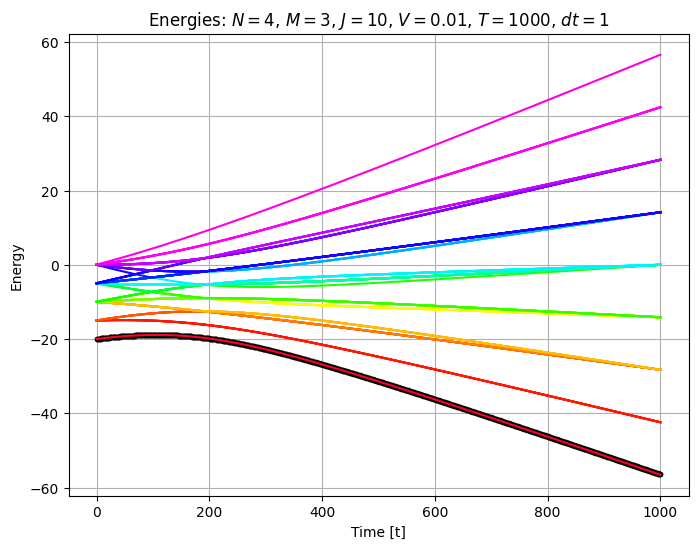

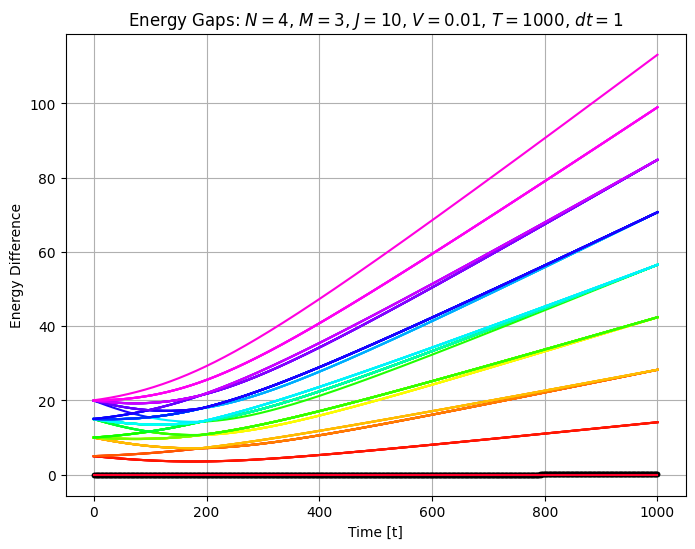

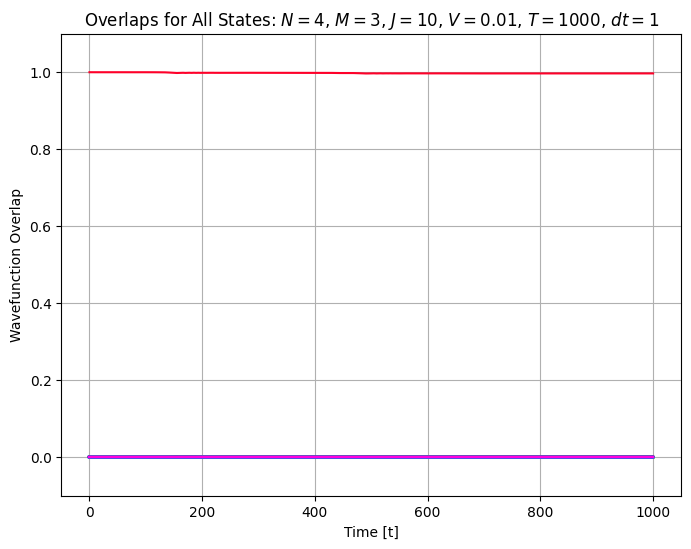

In [26]:
cmap = plt.get_cmap("gist_rainbow")
colors = [cmap(i / (n_excited_states + 1)) for i in range(n_excited_states + 1)]

# ------------------------------------------------------------------------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(times, adiabatic_energies, color="black", marker=".", linestyle="", label="$\Psi^\dagger(t) H \Psi(t)$")

for i in range(n_excited_states):
    ax.plot(times, true_energies[:, i], color=colors[i], label=f"$E_{i}$")

ax.set_title(f"Energies: $N=${N}, $M=${M}, $J = ${J}, $V = ${V}, $T=${t_total}, $dt=${np.round(dt, 3)}")
ax.set_xlabel("Time [t]")
ax.set_ylabel("Energy")
#ax.legend(loc="lower center", ncols = (n_excited_states+1)//2)
ax.grid(True)

# ------------------------------------------------------------------------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(times, adiabatic_diff, ".", color="black", label="$\Psi^\dagger(t) H \Psi(t) - E_0$")

for i in range(n_excited_states):
    ax.plot(times, energy_gaps[:, i], color=colors[i], label=f"$\Delta E = E_{i}-E_0$")

ax.set_title(f"Energy Gaps: $N=${N}, $M=${M}, $J = ${J}, $V = ${V}, $T=${t_total}, $dt=${np.round(dt, 3)}")
ax.set_xlabel("Time [t]")
ax.set_ylabel("Energy Difference")
#ax.legend(loc="upper center", ncols = (n_excited_states+1)//2)
ax.grid(True)

# ------------------------------------------------------------------------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(n_excited_states):
    ax.plot(times, overlaps_all_states[:, i], color=colors[i], label=f"$\Psi(t)^\dagger \Psi_{i}$")

ax.set_title(f"Overlaps for All States: $N=${N}, $M=${M}, $J = ${J}, $V = ${V}, $T=${t_total}, $dt=${np.round(dt, 3)}")
ax.set_xlabel("Time [t]")
ax.set_ylabel("Wavefunction Overlap")
#ax.legend(loc="center left")
ax.grid(True)
ax.set_ylim(-0.1, 1.1)

<>:9: SyntaxWarning: invalid escape sequence '\P'
<>:21: SyntaxWarning: invalid escape sequence '\P'
<>:23: SyntaxWarning: invalid escape sequence '\D'
<>:35: SyntaxWarning: invalid escape sequence '\P'
<>:9: SyntaxWarning: invalid escape sequence '\P'
<>:21: SyntaxWarning: invalid escape sequence '\P'
<>:23: SyntaxWarning: invalid escape sequence '\D'
<>:35: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Joe\AppData\Local\Temp\ipykernel_23596\3503979898.py:9: SyntaxWarning: invalid escape sequence '\P'
  ax.plot(times, adiabatic_energies, color="black", marker=".", linestyle="", label="$\Psi^\dagger(t) H \Psi(t)$")
C:\Users\Joe\AppData\Local\Temp\ipykernel_23596\3503979898.py:21: SyntaxWarning: invalid escape sequence '\P'
  ax.plot(times, adiabatic_diff, ".", color="black", label="$\Psi^\dagger(t) H \Psi(t) - E_0$")
C:\Users\Joe\AppData\Local\Temp\ipykernel_23596\3503979898.py:23: SyntaxWarning: invalid escape sequence '\D'
  ax.plot(times, energy_gaps[:, i], color=colors[i], l

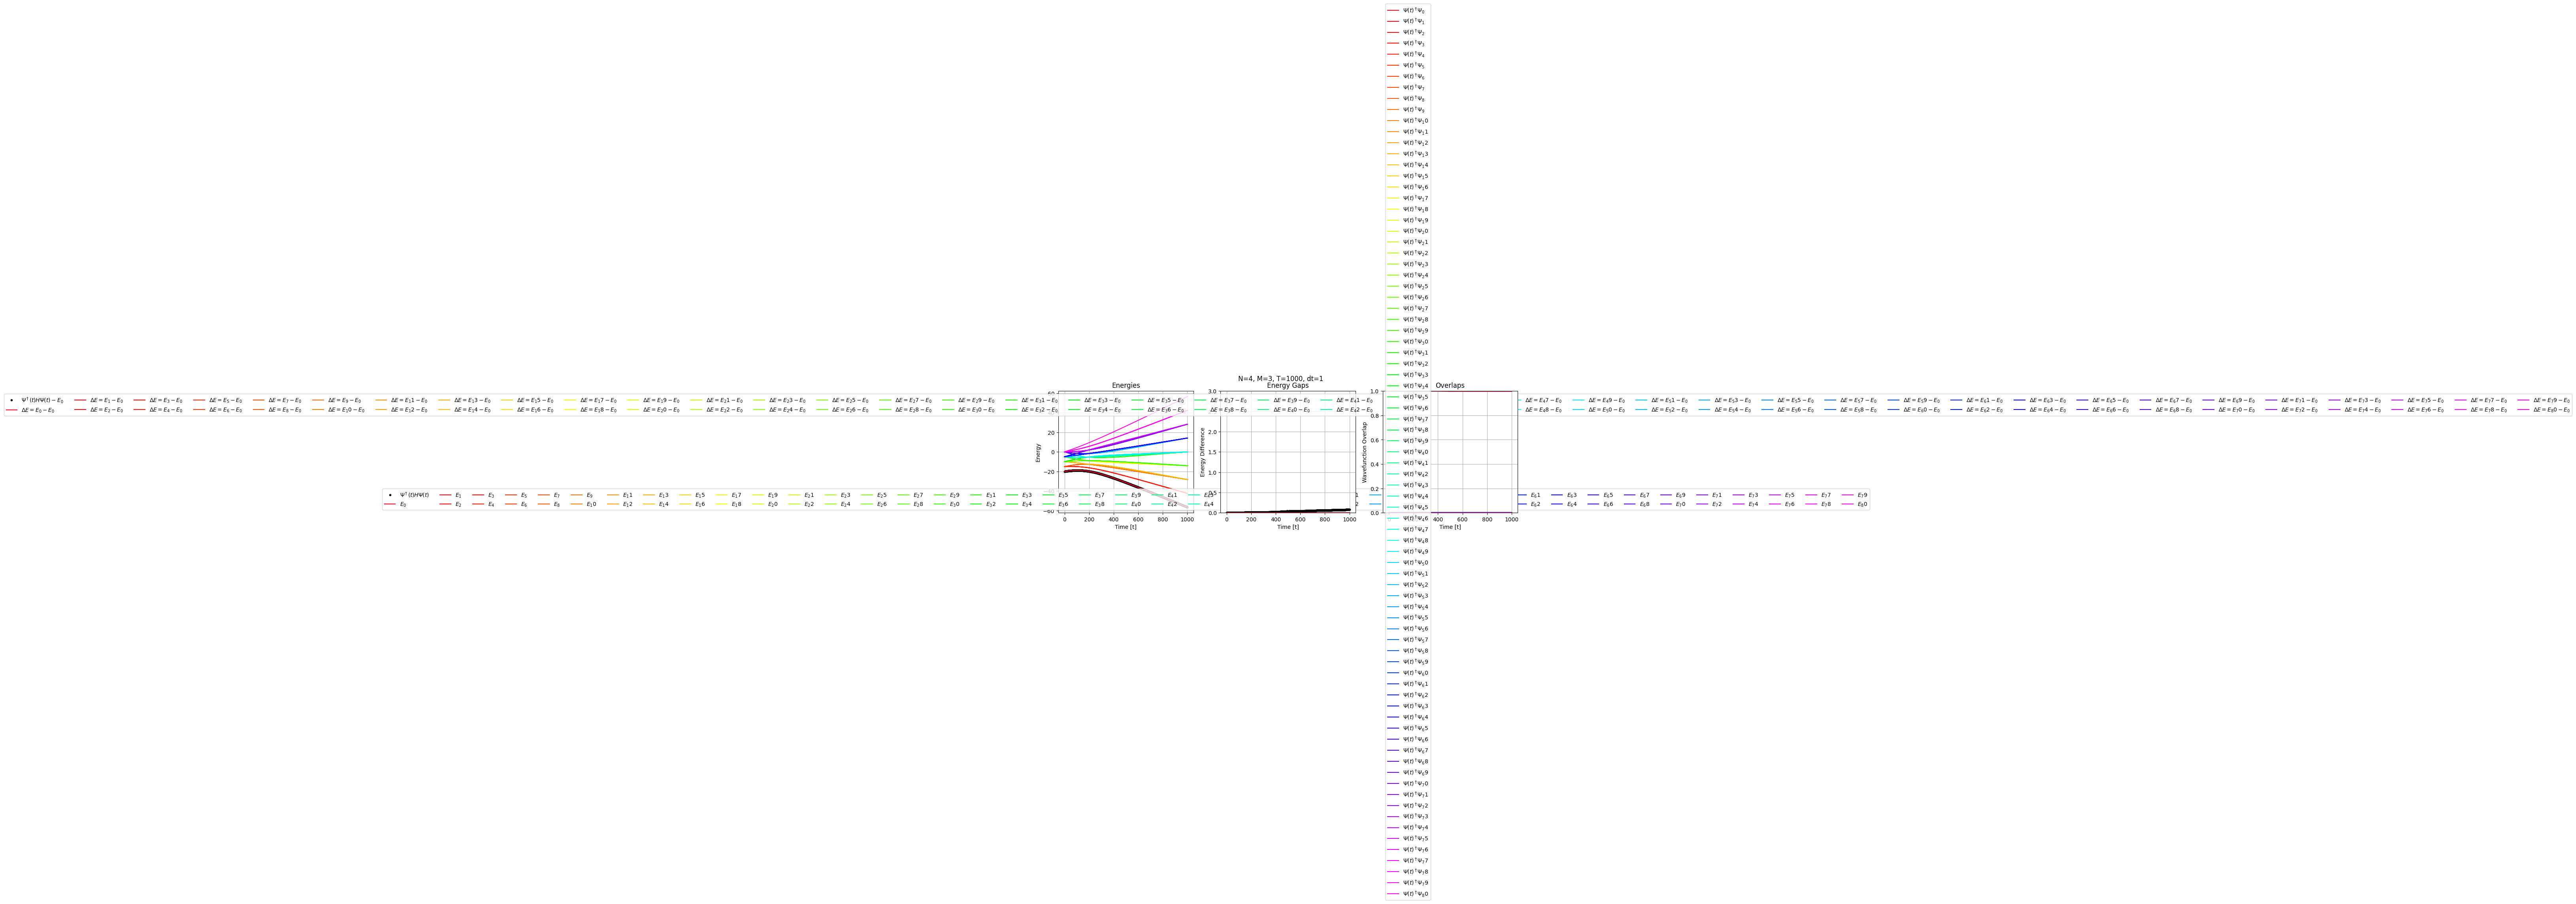

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

cmap = plt.get_cmap("gist_rainbow")
colors = [cmap(i / (n_excited_states + 1)) for i in range(n_excited_states + 1)]
fig.suptitle(f"N={N}, M={M}, T={t_total}, dt={np.round(dt, 3)}")

# first plot: Energies vs Time
ax = axes[0]
ax.plot(times, adiabatic_energies, color="black", marker=".", linestyle="", label="$\Psi^\dagger(t) H \Psi(t)$")
for i in range(n_excited_states):
    ax.plot(times, true_energies[:, i], color=colors[i], label=f"$E_{i}$")

ax.set_title(f"Energies")
ax.set_xlabel("Time [t]")
ax.set_ylabel("Energy")
ax.legend(loc="lower center", ncol=(n_excited_states+1)//2)
ax.grid(True)

# second plot: Energy Gaps vs Time
ax = axes[1]
ax.plot(times, adiabatic_diff, ".", color="black", label="$\Psi^\dagger(t) H \Psi(t) - E_0$")
for i in range(n_excited_states):
    ax.plot(times, energy_gaps[:, i], color=colors[i], label=f"$\Delta E = E_{i}-E_0$")

ax.set_title(f"Energy Gaps")
ax.set_xlabel("Time [t]")
ax.set_ylabel("Energy Difference")
ax.legend(loc="upper center", ncol=(n_excited_states+1)//2)
ax.grid(True)
ax.set_ylim(0, 3)

# third plot: Overlaps vs Time
ax = axes[2]
for i in range(n_excited_states):
    ax.plot(times, overlaps_all_states[:, i], color=colors[i], label=f"$\Psi(t)^\dagger \Psi_{i}$")

ax.set_title(f"Overlaps")
ax.set_xlabel("Time [t]")
ax.set_ylabel("Wavefunction Overlap")
ax.legend(loc="center left")
ax.grid(True)
ax.set_ylim(0, 1)

fig.tight_layout()

